# Training Notebook

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from MPCNet.dataset import dataset
from MPCNet.controller import utils
from MPCNet.simulation import simulation
from sklearn import preprocessing

2022-04-14 17:11:12.617650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-14 17:11:12.617669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
X_raw,y = dataset.Dataset.load('data/data5-1000000.csv')

In [4]:
#scaler = preprocessing.StandardScaler().fit(X_raw)
#X = scaler.transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, random_state=42)

In [36]:
normalizationLayer = tf.keras.layers.Normalization(axis=-1, input_dim=5)
normalizationLayer.adapt(X_train)

In [37]:
batch_size, lr, num_epochs = 20000, 0.001, 50
loss = tf.keras.losses.MeanSquaredError()
trainer = tf.keras.optimizers.Adam(learning_rate=lr)

In [38]:
net = tf.keras.models.Sequential([
    normalizationLayer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)
])
net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_14 (Dense)            (None, 64)                384       
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [39]:
net.compile(trainer, loss)
net.fit(
    x = X_train,
    y = y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    use_multiprocessing=True)

Epoch 1/50
36/36 [==============================] - 2s 28ms/step - loss: 0.4597 - val_loss: 0.6647
Epoch 2/50
36/36 [==============================] - 1s 25ms/step - loss: 0.2161 - val_loss: 0.4945
Epoch 3/50
36/36 [==============================] - 1s 25ms/step - loss: 0.1451 - val_loss: 0.3720
Epoch 4/50
36/36 [==============================] - 1s 25ms/step - loss: 0.1303 - val_loss: 0.2984
Epoch 5/50
36/36 [==============================] - 1s 24ms/step - loss: 0.1240 - val_loss: 0.2504
Epoch 6/50
36/36 [==============================] - 1s 25ms/step - loss: 0.1199 - val_loss: 0.2141
Epoch 7/50
36/36 [==============================] - 1s 25ms/step - loss: 0.1170 - val_loss: 0.1833
Epoch 8/50
36/36 [==============================] - 1s 25ms/step - loss: 0.1148 - val_loss: 0.1613
Epoch 9/50
36/36 [==============================] - 1s 25ms/step - loss: 0.1129 - val_loss: 0.1470
Epoch 10/50
36/36 [==============================] - 1s 25ms/step - loss: 0.1112 - val_loss: 0.1318
Epoch 11/

In [40]:
net.evaluate(x=X_test, y=y_test)

6250/6250 [==============================] - 15s 2ms/step - loss: 0.0900


0.09002034366130829

In [41]:
net.save('model.hdf5')

In [42]:
loaded_model = tf.keras.models.load_model('model.hdf5')
def nnController(initialState, finalState):
    relativeInitial, relativeFinal = utils.absoluteToRelative(initialState, finalState)
    inputVector = tf.constant([
        relativeInitial[0],
        relativeFinal[0],
        relativeFinal[1],
        relativeFinal[2],
        relativeFinal[3]
    ], shape=(1,5))
    #normalizedInput = scaler.transform(inputVector)
    predictedControl = loaded_model.predict(inputVector)
    return np.array([predictedControl[0][0], predictedControl[0][1]], dtype=np.double)

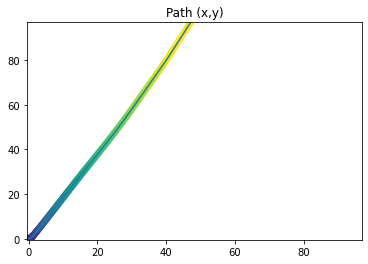

In [43]:
initialState = np.array([0, 0, 0, 0], dtype=np.double)
targetState = np.array([50, 100, 0, 0], dtype=np.double)

sim = simulation.Simulation(
    initialState,
    targetState,
    10.0,
    nnController,
    stopRadius=5.0)

sim.runSimulation(50.0, quiet=True)
simulation.plot_path(sim)